# Hello World

This notebook walks through basic code examples for integrating various packages with Neo4j, including `py2neo`, `ipython-cypher`, `pandas`, `networkx`, `igraph`, and `jgraph`.

# py2neo

`py2neo` is one of Neo4j's Python drivers. It offers a fully-featured interface for interacting with your data in Neo4j. Install `py2neo` with `pip install py2neo`.

## Connect

Connect to Neo4j with the `Graph` class.

In [1]:
from py2neo import Graph

graph = Graph()

In [2]:
graph.delete_all()

## Nodes

Create nodes with the `Node` class. The first argument is the node's label. The remaining arguments are an arbitrary amount of node properties or key-value pairs.

In [3]:
from py2neo import Node

nicole = Node("Person", name="Nicole", age=24)
drew = Node("Person", name="Drew", age=20)

mtdew = Node("Drink", name="Mountain Dew", calories=9000)
cokezero = Node("Drink", name="Coke Zero", calories=0)

coke = Node("Manufacturer", name="Coca Cola")
pepsi = Node("Manufacturer", name="Pepsi")

for _ in [nicole, drew, mtdew, cokezero, coke, pepsi]: 
    graph.create(_)

In [4]:
from scripts.vis import draw

options = {"Person": "name", "Drink": "name", "Manufacturer": "name"}
draw(graph, options)

P.S. - If you want to check out what's going on behind the scenes for the `draw()` function used above, take a look at [`scripts/vis.py`](https://github.com/nicolewhite/neo4j-jupyter/blob/master/scripts/vis.py).

## Relationships

Create relationships between nodes with the `Relationship` class.

In [5]:
from py2neo import Relationship

graph.create(Relationship(nicole, "LIKES", cokezero))
graph.create(Relationship(nicole, "LIKES", mtdew))
graph.create(Relationship(drew, "LIKES", mtdew))
graph.create(Relationship(coke, "MAKES", cokezero))
graph.create(Relationship(pepsi, "MAKES", mtdew))

draw(graph, options)

## Cypher

~~Retrieve Cypher query results with `Graph.cypher.execute`.~~

According to the [v3 Documentation for py2neo](http://py2neo.org/v3/database.html#the-graph):

> **Note:** The previous version of py2neo allowed Cypher execution through `Graph.cypher.execute()`. This facility is now instead accessible via `Graph.run()` and returns a lazily-evaluated `Cursor` rather than an eagerly-evaluated `RecordList`.

In [6]:
query = """
MATCH (person:Person)-[:LIKES]->(drink:Drink)
RETURN person.name AS name, drink.name AS drink
"""

data = [_ for _ in graph.run(query)]

data

[('name': 'Nicole', 'drink': 'Mountain Dew'),
 ('name': 'Nicole', 'drink': 'Coke Zero'),
 ('name': 'Drew', 'drink': 'Mountain Dew')]

In [7]:
data[0]

('name': 'Nicole', 'drink': 'Mountain Dew')

In [8]:
for row in data:
    print("{name} likes to drink {drink}.".format(**row))

Nicole likes to drink Mountain Dew.
Nicole likes to drink Coke Zero.
Drew likes to drink Mountain Dew.


## Parameterized Cypher

Pass parameters to Cypher queries by passing additional key-value arguments to `Graph.cypher.execute.` Parameters in Cypher are named and are wrapped in curly braces.

In [9]:
query = """
MATCH (p:Person)-[:LIKES]->(drink:Drink)
WHERE p.name = {name}
RETURN p.name AS name, AVG(drink.calories) AS avg_calories
"""

data = graph.run(query, name="Nicole")

data.dump()

 name    avg_calories 
----------------------
 Nicole  4500.0       


# ipython-cypher

`ipython-cypher` exposes `%cypher` magic in Jupyter. Install `ipython-cypher` with `pip install ipython-cypher`.

In [10]:
%load_ext cypher

/opt/conda/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/opt/conda/lib/python3.5/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


## Cypher

`%cypher` is intended for one-line Cypher queries and `%%cypher` is intended for multi-line Cypher queries. Placing `%%cypher` above a Cypher query will display that query's results.

In [11]:
%%cypher
MATCH (person:Person)-[:LIKES]->(drink:Drink)
RETURN person.name, drink.name, drink.calories

3 rows affected.


person.name,drink.name,drink.calories
Nicole,Mountain Dew,9000
Nicole,Coke Zero,0
Drew,Mountain Dew,9000


## Pandas Data Frames

Cypher query results can be coerced to `pandas` data frames with the `get_dataframe` method. To assign Cypher query results to a variable, you need to use `%cypher` and separate lines with \\. You'll first need to install `pandas` with `pip install pandas`.

In [12]:
results = %cypher MATCH (person:Person)-[:LIKES]->(drink:Drink) \
                  RETURN person.name AS name, drink.name AS drink
    
df = results.get_dataframe()

df

3 rows affected.


,name,drink
0,Nicole,Mountain Dew
1,Nicole,Coke Zero
2,Drew,Mountain Dew


In [13]:
df.index

RangeIndex(start=0, stop=3, step=1)

In [14]:
df.iloc[[1]]

,name,drink
1,Nicole,Coke Zero


In [15]:
df["name"]

0    Nicole
1    Nicole
2      Drew
Name: name, dtype: object

## NetworkX Graphs

Cypher query results can be coerced to `NetworkX` MultiDiGraphs, graphs that permit multiple edges between nodes, with the `get_graph` method. You'll first need to install `NetworkX` with `pip install networkx`.

3 rows affected.


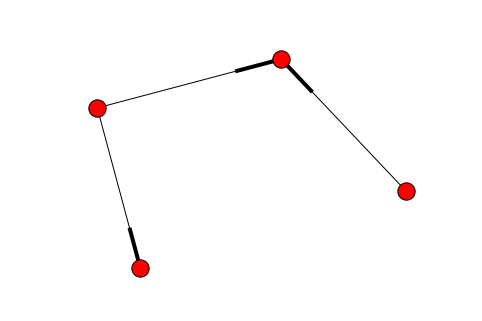

In [16]:
import networkx as nx
%matplotlib inline

results = %cypher MATCH p = (:Person)-[:LIKES]->(:Drink) RETURN p

g = results.get_graph()

nx.draw(g)

In [17]:
g.nodes(data=True)

[('123', {'calories': 0, 'labels': ['Drink'], 'name': 'Coke Zero'}),
 ('120', {'age': 24, 'labels': ['Person'], 'name': 'Nicole'}),
 ('122', {'calories': 9000, 'labels': ['Drink'], 'name': 'Mountain Dew'}),
 ('121', {'age': 20, 'labels': ['Person'], 'name': 'Drew'})]

In [18]:
nx.degree(g)

{'120': 2, '121': 1, '122': 2, '123': 1}

# igraph

Cypher query results can be imported into `igraph` with `py2neo`. You'll need to install `igraph` with `pip install python-igraph`. Query results should be returned as edgelists, as `igraph` has a method for building an `igraph` object from a list of tuples representing edges between nodes.

In [19]:
from py2neo import Graph as PGraph
from igraph import Graph as IGraph

neo4j = PGraph()

query = """
MATCH (person:Person)-[:LIKES]->(drink:Drink)
RETURN person.name, drink.name
"""

data = [_ for _ in neo4j.run(query)]
data

[('person.name': 'Nicole', 'drink.name': 'Mountain Dew'),
 ('person.name': 'Nicole', 'drink.name': 'Coke Zero'),
 ('person.name': 'Drew', 'drink.name': 'Mountain Dew')]

In [20]:
ig = IGraph.TupleList(data)

ig

In [21]:
best = ig.vs.select(_degree = ig.maxdegree())["name"]
best

['Nicole', 'Mountain Dew']

# jgraph

`jgraph` will plot tuple lists as 3D graphs.

In [22]:
import jgraph

jgraph.draw([(1, 2), (2, 3), (3, 4), (4, 1), (4, 5), (5, 2)])

In [24]:
data = graph.run("MATCH (n)-->(m) RETURN ID(n), ID(m)")
data = [tuple(x) for x in data]

jgraph.draw(data)